In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from astropy.table import Table

In [2]:
import matplotlib
matplotlib.rcParams.update({'font.size':18})
matplotlib.rcParams.update({'font.family':'serif'})

Text(0.5, 1.0, 'GJ 1243')

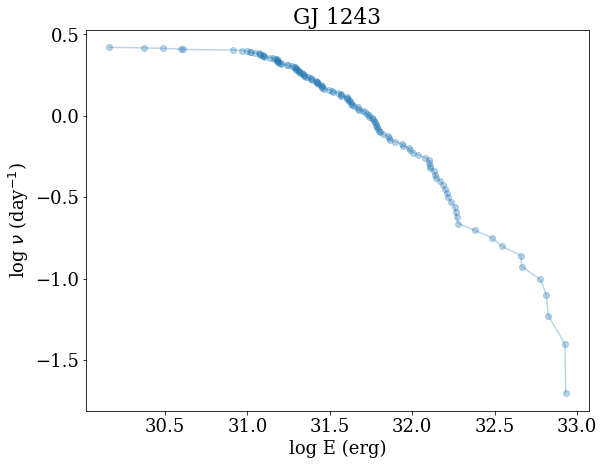

In [121]:
# TESS Luminosity
LUMIN = 31.061790465873248 # from "padova_lum" notebook
LUMIN_err = 0.039444830755122
# Kepler Luminosity
E_POINT = 30.67828435767249 # from "padova_lum" notebook
E_POINT_err = 0.04457627419541614
gj1243_dir = '../gj1243_10yrs/'

file = gj1243_dir + 'gj1243_tess.dat.fbeye'
colnames = ('Event_ID', 'Start_INDX', 'Stop_INDX', 't_peak', 't_start', 't_stop', 't_rise', 't_decay', 
            'Flux_peak', 'Equiv_Dur', 'S/N', 'CPLX_flg', 'MLTPK_flg', 'MLTPK_num', 't_MLTPK', 'L_mltpk', 
            'MLTPK_INDX', 'quies','x')

fbeye = pd.read_table(file, sep='\s+', comment='#', names=colnames)[1:] # skip the first junk row

file2 = gj1243_dir + 'gj1243_tess15.dat.fbeye'
fbeye2 = pd.read_table(file2, sep='\s+', comment='#', names=colnames)[1:] # skip the first junk row


file = gj1243_dir + 'tess2019198215352-s0014-0000000273589987-0150-s_lc.fits'
tbl = Table.read(file, format='fits')
q = tbl['QUALITY'] == 0

file2 = gj1243_dir + 'tess2019226182529-s0015-0000000273589987-0151-s_lc.fits'
tbl2 = Table.read(file2, format='fits')
q2 = tbl2['QUALITY'] == 0
dt = np.nanmedian(np.diff(tbl['TIME'][q]))

ED = np.sort(np.concatenate((fbeye['Equiv_Dur'].values, fbeye2['Equiv_Dur'].values)))[::-1]
TOTDUR = dt * (sum(q) + sum(q2)) # days

ffd_x = np.log10(ED) + LUMIN
ffd_y = np.log10(np.arange(1, len(ED)+1) / TOTDUR)

plt.figure(figsize=(9,7))
plt.plot(ffd_x, ffd_y, '-o', color='C0', alpha=0.3)
plt.xlabel('log E (erg)')
plt.ylabel(r'log $\nu$ (day$^{-1}$)')
plt.title('GJ 1243')

In [122]:
# gj1243 : G-J = 11.55090 - 8.586
# YZCMi : G-J =  9.6807 - 6.58

print(11.55090 - 8.586, 9.6807 - 6.58)

2.9649 3.1007


(144, 19)


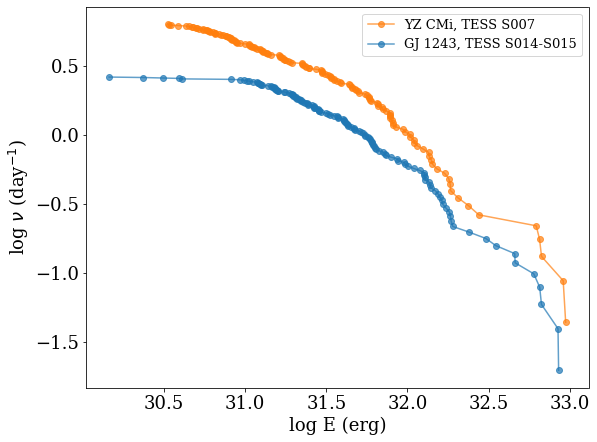

In [123]:
# LUMINY = 31.00192752813018 # from updated notebook (gj1243_10yrs/spectra/padova_lum)
# LUMINY_err = 0.22985294989763078

LUMINY  = 30.976368864140518 # from updated notebook (gj1243_10yrs/spectra/padova_lum)
LUMINY_err = 0.1148749988137026 # but using i-J instead of g-J b/c larger errors in g!

file = 'tess2019006130736-s0007-0000000266744225-0131-s_lc.fits.dat.fbeye'
fbeyeY = pd.read_table(file, sep='\s+', comment='#', names=colnames)[1:] # skip the first junk row

file = 'tess2019006130736-s0007-0000000266744225-0131-s_lc.fits'
tblY = Table.read(file, format='fits')
qY = tblY['QUALITY'] == 0
dt = np.nanmedian(np.diff(tblY['TIME'][qY]))

####
EDY = np.sort(fbeyeY['Equiv_Dur'].values)[::-1]
TOTDURY = dt * sum(qY) # days

ffd_xY = np.log10(EDY) + LUMINY
ffd_yY = np.log10(np.arange(1, len(EDY)+1) / TOTDURY)

plt.figure(figsize=(9,7))
plt.plot(ffd_xY, ffd_yY, '-o', color='C1', alpha=0.7, label='YZ CMi, TESS S007')
plt.plot(ffd_x, ffd_y, '-o', color='C0', alpha=0.7, label='GJ 1243, TESS S014-S015')
plt.legend(fontsize=13)
plt.xlabel('log E (erg)')
plt.ylabel(r'log $\nu$ (day$^{-1}$)')
# plt.title('GJ 1243')

print(fbeyeY.shape)

2.772606015570289


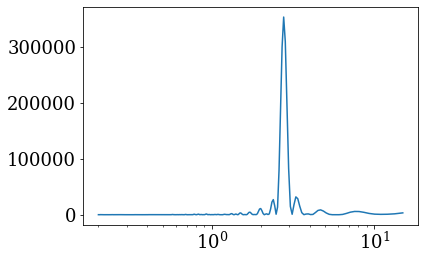

In [124]:
# plt.plot(tblY['TIME'][qY], tblY['PDCSAP_FLUX'][qY])
import exoplanet as xo

lnp = xo.lomb_scargle_estimator(tblY['TIME'][qY].data, tblY['PDCSAP_FLUX'][qY].data, min_period=0.2, max_period=15)

freq, pwr = lnp['periodogram']
plt.plot(1./freq, pwr)
plt.xscale('log')

print(lnp['peaks'][0]['period'])

In [125]:
import sys
sys.path
sys.path.append('/Users/james/python/FFD/')
from FFD import FFD, FlareKernel

#gj1243
ffd_x,ffd_ylog,ffd_xerr,ffd_yerrlog = FFD(np.concatenate((fbeye['Equiv_Dur'].values, 
                                    fbeye2['Equiv_Dur'].values)), TOTEXP=TOTDUR, Lum=LUMIN, 
                    dur=np.concatenate((fbeye['t_stop'].values-fbeye['t_start'].values, 
                                        fbeye2['t_stop'].values-fbeye2['t_start'].values)), 
                    fluxerr=np.nanmedian(tbl['PDCSAP_FLUX_ERR'][q] / np.nanmedian(tbl['PDCSAP_FLUX'][q])),logY=True)

ffd_x,ffd_y,ffd_xerr,ffd_yerr = FFD(np.concatenate((fbeye['Equiv_Dur'].values, 
                                    fbeye2['Equiv_Dur'].values)), TOTEXP=TOTDUR, Lum=LUMIN, 
                    dur=np.concatenate((fbeye['t_stop'].values-fbeye['t_start'].values, 
                                        fbeye2['t_stop'].values-fbeye2['t_start'].values)), 
                    fluxerr=np.nanmedian(tbl['PDCSAP_FLUX_ERR'][q] / np.nanmedian(tbl['PDCSAP_FLUX'][q])),logY=False)

#yzcmi
ffd_xY,ffd_yYlog,ffd_xerrY,ffd_yerrYlog = FFD(fbeyeY['Equiv_Dur'].values, TOTEXP=TOTDURY, Lum=LUMINY, 
                                        dur=fbeyeY['t_stop'].values-fbeyeY['t_start'].values, 
                fluxerr=np.nanmedian(tblY['PDCSAP_FLUX_ERR'][qY] / np.nanmedian(tblY['PDCSAP_FLUX'][qY])),logY=True)

ffd_xY,ffd_yY,ffd_xerrY,ffd_yerrY = FFD(fbeyeY['Equiv_Dur'].values, TOTEXP=TOTDURY, Lum=LUMINY, 
                                        dur=fbeyeY['t_stop'].values-fbeyeY['t_start'].values, 
                fluxerr=np.nanmedian(tblY['PDCSAP_FLUX_ERR'][qY] / np.nanmedian(tblY['PDCSAP_FLUX'][qY])),logY=False )


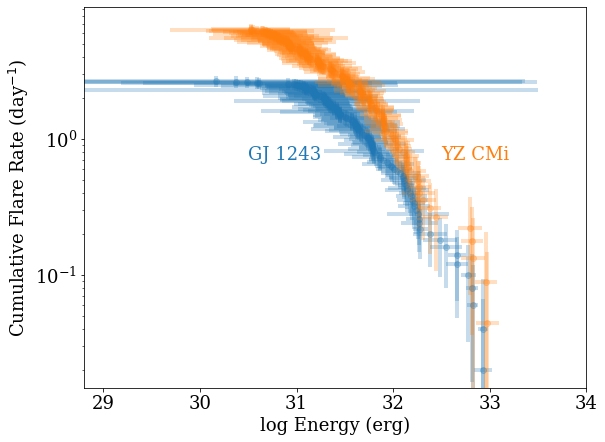

In [126]:
plt.figure(figsize=(9,7))

plt.errorbar(ffd_x, ffd_y, xerr=np.sqrt(ffd_xerr**2+LUMIN_err**2), 
             yerr=ffd_yerr, 
             color='C0', alpha=0.25, linestyle='none', lw=4, marker='o')

plt.errorbar(ffd_xY, ffd_yY, xerr=np.sqrt(ffd_xerrY**2+LUMINY_err**2), 
             yerr=ffd_yerrY, 
             color='C1', alpha=0.25, linestyle='none', lw=4, marker='o')


plt.yscale('log')

plt.xlabel('log Energy (erg)')
plt.ylabel(r'Cumulative Flare Rate (day$^{-1}$)')
# plt.title('GJ 1243 (M4, P$_{rot}$=0.59d)', fontsize=14)

# plt.text(31.5, 5, 'Kepler',color='k')
plt.text(30.5, 0.7,'GJ 1243', color='C0')
plt.text(32.5, 0.7,'YZ CMi', color='C1')
plt.xlim(28.8,34)

plt.savefig('YZCMI_vs_GJ1243.png', dpi=150, bbox_inches='tight', pad_inches=0.25)

## fitting the FFD
there's lots of ways to fit a FFD, perhaps none of the good

In [127]:
from scipy.odr import ODR, Model, Data, RealData

In [171]:
def f(B, x):
    if B[0] > 0:
        return np.inf
#     B[0] = -1 # fix slope? no
    return 10**(B[0]*x + B[1])

In [172]:
def quickfit(x,y,xe,ye):
    
    b00, b10 = -1., 30

    linear = Model(f)
    ok = np.where(np.isfinite(x) & np.isfinite(y) & np.isfinite(xe) & np.isfinite(ye))[0]
    mydata = RealData(x[ok], y[ok], sx=xe[ok], sy=ye[ok])
    myodr = ODR(mydata, linear, beta0=[b00, b10])
    myoutput = myodr.run()

    m, b = myoutput.beta[0], myoutput.beta[1]
    m_err, b_err = myoutput.sd_beta[0], myoutput.sd_beta[1]

    return m,b,m_err,b_err
    

-0.8674486228408193 27.474273026583035 0.01596490824185898 0.5073678493066982
-0.720334629224622 23.04796477252274 0.017517945270189045 0.5521330235705368


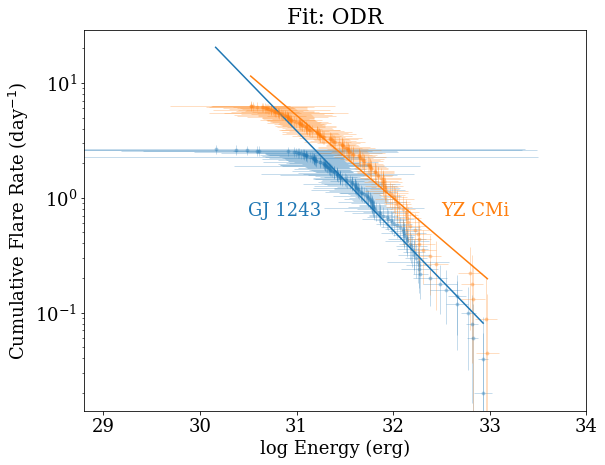

In [174]:
plt.figure(figsize=(9,7))

plt.errorbar(ffd_x, ffd_y, xerr=np.sqrt(ffd_xerr**2+LUMIN_err**2), 
             yerr=ffd_yerr, 
             color='C0', alpha=0.25, linestyle='none', lw=1, marker='.')

plt.errorbar(ffd_xY, ffd_yY, xerr=np.sqrt(ffd_xerrY**2+LUMINY_err**2), 
             yerr=ffd_yerrY, 
             color='C1', alpha=0.25, linestyle='none', lw=1, marker='.')

m,b,m_err,b_err = quickfit(ffd_x, ffd_y, 
                           np.sqrt(ffd_xerr**2+LUMIN_err**2), ffd_yerr)
mY,bY,m_errY,b_errY = quickfit(ffd_xY, ffd_yY, 
                               np.sqrt(ffd_xerrY**2+LUMINY_err**2), ffd_yerrY)

plt.plot(ffd_x, 10**(m*ffd_x + b))
plt.plot(ffd_xY, 10**(mY*ffd_xY + bY))

plt.yscale('log')

plt.xlabel('log Energy (erg)')
plt.ylabel(r'Cumulative Flare Rate (day$^{-1}$)')
# plt.title('GJ 1243 (M4, P$_{rot}$=0.59d)', fontsize=14)

# plt.text(31.5, 5, 'Kepler',color='k')
plt.text(30.5, 0.7,'GJ 1243', color='C0')
plt.text(32.5, 0.7,'YZ CMi', color='C1')
plt.xlim(28.8,34)

plt.title('Fit: ODR')
# plt.savefig('YZCMI_vs_GJ1243.png', dpi=150, bbox_inches='tight', pad_inches=0.25)


print(m,b,m_err,b_err)
print(mY,bY,m_errY,b_errY)

In [187]:
# try fitting straight line w/ MCMC
# https://emcee.readthedocs.io/en/stable/tutorials/line/

def log_prior(theta):
    m, b, log_f = theta
    if -5.0 < m < 0 and 0.0 < b < 1000 and -10.0 < log_f < 1.0:
        return 0.0
    return -np.inf

def log_likelihood(theta, x, y, xerr, yerr):
    m, b, log_f = theta
    model = 10**(m * x + b)
    xmodel = (np.log10(y) - b)/m
#     sigma2 = yerr ** 2 + model ** 2 * np.exp(2 * log_f)
#     return -0.5 * np.sum((y - model) ** 2 / sigma2 + np.log(sigma2))
    return -0.5 * (np.sum(((y - model)/yerr )** 2) + np.sum(((x - xmodel)/xerr )** 2))

def log_probability(theta, x, y, xerr, yerr):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y, xerr, yerr)

def therng(thething, rng=[15,50,84]):
    pcent = np.percentile(thething, rng)
    q = np.diff(pcent)
    return pcent[1], q[0], q[1]

In [194]:
import emcee

# add extra dimension for additional variance, per emcee docs
pos = np.array([-1, b, 0.]) + 1e-4 * np.random.randn(32, 3)
nwalkers, ndim = pos.shape

In [199]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, 
                                args=(ffd_xY[0:70], ffd_yY[0:70], ffd_xerrY[0:70], ffd_yerrY[0:70]))
sampler.run_mcmc(pos, 1000, progress=True);
samples = sampler.get_chain()
flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)

100%|██████████| 1000/1000 [00:01<00:00, 629.28it/s]


(-1.1086374131293555, 0.010176030363704403, 0.010192513897855138)


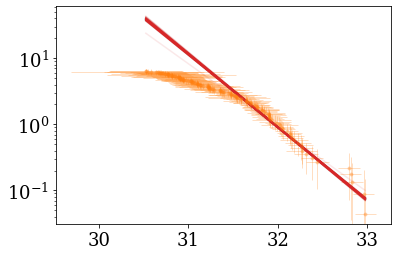

In [200]:
inds = np.random.randint(len(flat_samples), size=100)
for ind in inds:
    sample = flat_samples[ind]
    plt.plot(ffd_xY, 10**(sample[0]*ffd_xY + sample[1]), "C3", alpha=0.1)

    
plt.errorbar(ffd_xY, ffd_yY, xerr=np.sqrt(ffd_xerrY**2+LUMINY_err**2), 
             yerr=ffd_yerrY, 
             color='C1', alpha=0.25, linestyle='none', lw=1, marker='.')
plt.yscale('log')

print(therng(flat_samples[:,0])) # the slope